# Artificial Intelligence Nanodegree

## Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this IPython notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Use a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 6](#step6): Write your Algorithm
* [Step 7](#step7): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

### Import Dog Dataset

In the code cell below, we import a dataset of dog images.  We populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
test_files, test_targets = load_dataset('dogImages/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

Using TensorFlow backend.


There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


### Import Human Dataset

In the code cell below, we import a dataset of human images, where the file paths are stored in the numpy array `human_files`.

In [2]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


---
<a id='step1'></a>
## Step 1: Detect Humans

We use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.

In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


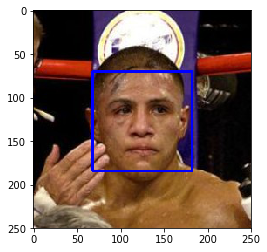

In [3]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[3])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [4]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__

__Percentage of first 100 images in human_files with a detected human face: 98.0%__

__Percentage of first 100 images in dog_files with a detected human face: 11.0%__

In [5]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]
# Do NOT modify the code above this line.

## Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
accuracy_human=[None]*len(human_files_short)
accuracy_dog=[None]*len(dog_files_short)
i=0
for human in human_files_short:
    accuracy_human[i] = face_detector(human)
    i=i+1
accuracy_human=np.array(accuracy_human).astype(int)
print('Percentage of first ' + str(accuracy_human.size) + ' images in human_files with a detected human face: '+str((np.sum(accuracy_human)/accuracy_human.size)*100) + '%')

i=0
for dogs in dog_files_short:
    accuracy_dog[i] = face_detector(dogs)
    i=i+1
accuracy_dog=np.array(accuracy_dog).astype(int)
print('Percentage of first ' + str(accuracy_dog.size) + ' images in dog_files with a detected human face: '+str((np.sum(accuracy_dog)/accuracy_dog.size)*100) + '%')

Percentage of first 100 images in human_files with a detected human face: 98.0%
Percentage of first 100 images in dog_files with a detected human face: 11.0%


__Question 2:__ This algorithmic choice necessitates that we communicate to the user that we accept human images only when they provide a clear view of a face (otherwise, we risk having unneccessarily frustrated users!). In your opinion, is this a reasonable expectation to pose on the user? If not, can you think of a way to detect humans in images that does not necessitate an image with a clearly presented face?

__Answer:__ This is could be interpretted both ways, for this specific task we are looking to find what dog breed the human most resembles and for that use case you would definitely would incline towards having a clear view of the human, to maximise the probability of having a good match between the face and the dog breed. 

On the other hand, you would not want to impose this rule since that would lead to a not so efficient model, since ideally we would like the face detector to be able to detect human faces even in images that don't have a clear view of the face.

One way we could do this is to detect other human body parts. This would definitely work if the image is not a close up view of the face but instead where the body of the human is also visible. The pre-trained detector (haarcascade_fullbody.xml) can be used in this case. This though does not work well for the images provided since the image is a close up. May be the best suggestion would try a combination of face detectors to improve accuracy but we have to run a fine line such that we dont improve the accuracy of finding humans by significantly increasing the false positives. 

In the (haarcascade_frontalface_alt2.xml) detector, that exactly is the case where the percentage of human face detected in dog images jumps to 20%. (see below)

<----------->

We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on each of the datasets.

### Testing another face detector algorithm

In [70]:

# Writing another face detector function that would take in another pre-trained face-detector as 
# an input (argument) into the function

face_cascade2 = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt2.xml')

# face_cascade2 = cv2.CascadeClassifier('haarcascades/haarcascade_fullbody.xml')

def face_detector_alt(img_path,face_cascade2):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade2.detectMultiScale(gray)
    return len(faces) > 0


In [71]:
# Testing the above face_detector

accuracy_human=[None]*len(human_files_short)
accuracy_dog=[None]*len(dog_files_short)
i=0
for human in human_files_short:
    accuracy_human[i] = face_detector_alt(human, face_cascade2)
    i=i+1
accuracy_human=np.array(accuracy_human).astype(int)
print('Percentage of first ' + str(accuracy_human.size) + ' images in human_files with a detected human face: '+str((np.sum(accuracy_human)/accuracy_human.size)*100) + '%')

i=0
for dogs in dog_files_short:
    accuracy_dog[i] = face_detector_alt(dogs, face_cascade2)
    i=i+1
accuracy_dog=np.array(accuracy_dog).astype(int)
print('Percentage of first ' + str(accuracy_dog.size) + ' images in dog_files with a detected human face: '+str((np.sum(accuracy_dog)/accuracy_dog.size)*100) + '%')

Percentage of first 100 images in human_files with a detected human face: 99.0%
Percentage of first 100 images in dog_files with a detected human face: 20.0%


---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images.  Our first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [73]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in your dataset!

In [74]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Making Predictions with ResNet-50

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing.  First, the RGB image is converted to BGR by reordering the channels.  All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image.  This is implemented in the imported function `preprocess_input`.  If you're curious, you can check the code for `preprocess_input` [here](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

Now that we have a way to format our image for supplying to ResNet-50, we are now ready to use the model to extract the predictions.  This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category.  This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [75]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need only check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive).

We use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [76]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

### (IMPLEMENTATION) Assess the Dog Detector

__Question 3:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 

In [13]:
### Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.
human_files_short = human_files[:100]
dog_files_short = train_files[:100]
 
accuracy_human=[None]*len(human_files_short)
accuracy_dog=[None]*len(dog_files_short)
i=0
for human in human_files_short:
    accuracy_human[i] = dog_detector(human)
    i=i+1
accuracy_human=np.array(accuracy_human).astype(int)
print('Percentage of first ' + str(accuracy_human.size) + ' images in human_files with a detected dog face: '+str((np.sum(accuracy_human)/accuracy_human.size)*100) + '%')

i=0
for dogs in dog_files_short:
    accuracy_dog[i] = dog_detector(dogs)
    i=i+1
accuracy_dog=np.array(accuracy_dog).astype(int)
print('Percentage of first ' + str(accuracy_dog.size) + ' images in dog_files with a detected dog face: '+str((np.sum(accuracy_dog)/accuracy_dog.size)*100) + '%')

Percentage of first 100 images in human_files with a detected dog face: 2.0%
Percentage of first 100 images in dog_files with a detected dog face: 100.0%


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 1%.  In Step 5 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

Be careful with adding too many trainable layers!  More parameters means longer training, which means you are more likely to need a GPU to accelerate the training process.  Thankfully, Keras provides a handy estimate of the time that each epoch is likely to take; you can extrapolate this estimate to figure out how long it will take for your algorithm to train. 

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have great difficulty in distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun! 

### Pre-process the Data

We rescale the images by dividing every pixel in every image by 255.

In [14]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 836/836 [00:05<00:00, 139.73it/s]


In [15]:
train_tensors.shape

(6680, 224, 224, 3)

### (IMPLEMENTATION) Augmentation of the training dataset

In order to try improving the model accuracy we use the image augmentation method on the training dataset and use that to train the CNN

In [16]:
from keras.preprocessing.image import ImageDataGenerator

# Create and configure augmented image generator

datagen_train = ImageDataGenerator(
    width_shift_range=0.2,  # randomly shift images horizontally (10% of total width)
    height_shift_range=0.2,  # randomly shift images vertically (10% of total height)
    horizontal_flip=True) # randomly flip images horizontally

datagen_train.fit(train_tensors)

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        model.summary()

We have imported some Python modules to get you started, but feel free to import as many modules as you need.  If you end up getting stuck, here's a hint that specifies a model that trains relatively fast on CPU and attains >1% test accuracy in 5 epochs:

![Sample CNN](images/sample_cnn.png)
           
__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  If you chose to use the hinted architecture above, describe why you think that CNN architecture should work well for the image classification task.

__Answer:__ 

In [72]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model = Sequential()

### Define your architecture.
# Based on the GPU, I beleive this CNN architecture should work well for image classification task, this CNN has 5
# convolution layer and a max pooling layer added to each of these layers. This way the total number of parameters is
# 208,949 parameters, this gives us some decent test accuracy of about ~40% with image augmentation. 
# Create the first Convolution layer:
model.add(Conv2D(filters=16, kernel_size=2, strides=1, padding='same', activation='relu', input_shape=(224,224,3)))

# Create the Max Pooling layer for the convolution layer:
model.add(MaxPooling2D(pool_size=2,strides=2))

# Create the first Convolution layer:
model.add(Conv2D(filters=32, kernel_size=2, strides=1, padding='same', activation='relu'))

# Create the Max Pooling layer for the convolution layer:
model.add(MaxPooling2D(pool_size=2,strides=2))

# Create the third Convolution layer:
model.add(Conv2D(filters=64, kernel_size=2, strides=1, padding='same', activation='relu'))

# Create the Max Pooling layer for the convolution layer:
model.add(MaxPooling2D(pool_size=2,strides=2))

# Create the third Convolution layer:
model.add(Conv2D(filters=128, kernel_size=2, strides=1, padding='same', activation='relu'))

# Create the Max Pooling layer for the convolution layer:
model.add(MaxPooling2D(pool_size=2,strides=2))

# Create the fourth Convolution layer:
model.add(Conv2D(filters=256, kernel_size=2, strides=1, padding='same', activation='relu'))

# Create the Max Pooling layer for the convolution layer:
model.add(MaxPooling2D(pool_size=2,strides=2))

# Create the Global Average Pooling layer:
model.add(GlobalAveragePooling2D())

# Create the final output layer:
### Reasoning: We define the output shape to be 133 since there are 133 dog breeds (133 classes) and use softmax
### activation function since we want to return the probability the image belonging to each class (dog breed).
model.add(Dense(133, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2826 (Conv2D)         (None, 224, 224, 16)      208       
_________________________________________________________________
max_pooling2d_127 (MaxPoolin (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_2827 (Conv2D)         (None, 112, 112, 32)      2080      
_________________________________________________________________
max_pooling2d_128 (MaxPoolin (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_2828 (Conv2D)         (None, 56, 56, 64)        8256      
_________________________________________________________________
max_pooling2d_129 (MaxPoolin (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_2829 (Conv2D)         (None, 28, 28, 128)       32896     
__________

# Compile the Model

In [36]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model (Without Image Augmentation)

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [37]:
from keras.callbacks import ModelCheckpoint 
import time

### specify the number of epochs that you would like to use to train the model.

Training_time_start_org = time.time()

epochs = 100

### Do NOT modify the code below this line.

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model_run_org=model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/100
6680/6680 [==============================] - 25s - loss: 4.8818 - acc: 0.0078 - val_loss: 4.8465 - val_acc: 0.0168
Epoch 2/100
6680/6680 [==============================] - 25s - loss: 4.8014 - acc: 0.0160 - val_loss: 4.7817 - val_acc: 0.0204
Epoch 3/100
6680/6680 [==============================] - 24s - loss: 4.6942 - acc: 0.0253 - val_loss: 4.6498 - val_acc: 0.0347
Epoch 4/100
6680/6680 [==============================] - 25s - loss: 4.5737 - acc: 0.0383 - val_loss: 4.5275 - val_acc: 0.0359
Epoch 5/100
6680/6680 [==============================] - 24s - loss: 4.4222 - acc: 0.0472 - val_loss: 4.4375 - val_acc: 0.0503
Epoch 6/100
6680/6680 [==============================] - 25s - loss: 4.3030 - acc: 0.0569 - val_loss: 4.3525 - val_acc: 0.0455
Epoch 7/100
6680/6680 [==============================] - 25s - loss: 4.1859 - acc: 0.0707 - val_loss: 4.2833 - val_acc: 0.0683
Epoch 8/100
6680/6680 [==============================] - 25s - l

6680/6680 [==============================] - 25s - loss: 2.7632 - acc: 0.3004 - val_loss: 3.5563 - val_acc: 0.1749
Epoch 29/100
6680/6680 [==============================] - 25s - loss: 2.6928 - acc: 0.3159 - val_loss: 3.6320 - val_acc: 0.2096
Epoch 30/100
6680/6680 [==============================] - 25s - loss: 2.6436 - acc: 0.3243 - val_loss: 3.4819 - val_acc: 0.1737
Epoch 31/100
6680/6680 [==============================] - 25s - loss: 2.5689 - acc: 0.3439 - val_loss: 3.6694 - val_acc: 0.1952
Epoch 32/100
6680/6680 [==============================] - 25s - loss: 2.5088 - acc: 0.3552 - val_loss: 3.3681 - val_acc: 0.2120
Epoch 33/100
6680/6680 [==============================] - 25s - loss: 2.4372 - acc: 0.3720 - val_loss: 3.7875 - val_acc: 0.1808
Epoch 34/100
6680/6680 [==============================] - 25s - loss: 2.3801 - acc: 0.3864 - val_loss: 3.4906 - val_acc: 0.2048
Epoch 35/100
6680/6680 [==============================] - 25s - loss: 2.3173 - acc: 0.3972 - val_loss: 3.5850 - val_a

6680/6680 [==============================] - 25s - loss: 0.3165 - acc: 0.9075 - val_loss: 6.2535 - val_acc: 0.2731
Epoch 94/100
6680/6680 [==============================] - 25s - loss: 0.3258 - acc: 0.9085 - val_loss: 6.1265 - val_acc: 0.2503
Epoch 95/100
6680/6680 [==============================] - 25s - loss: 0.3331 - acc: 0.9024 - val_loss: 5.7274 - val_acc: 0.3006
Epoch 96/100
6680/6680 [==============================] - 25s - loss: 0.3280 - acc: 0.9054 - val_loss: 6.7616 - val_acc: 0.2671
Epoch 97/100
6680/6680 [==============================] - 25s - loss: 0.3401 - acc: 0.9109 - val_loss: 5.7425 - val_acc: 0.2898
Epoch 98/100
6680/6680 [==============================] - 25s - loss: 0.3071 - acc: 0.9142 - val_loss: 6.1030 - val_acc: 0.2922
Epoch 99/100
6680/6680 [==============================] - 25s - loss: 0.3045 - acc: 0.9148 - val_loss: 6.7059 - val_acc: 0.2910
Epoch 100/100
6680/6680 [==============================] - 25s - loss: 0.3005 - acc: 0.9126 - val_loss: 6.3137 - val_

In [41]:
Training_time_without_Aug=int(time.time()-Training_time_start_org)
print("Total Training Time: " + str(Training_time_without_Aug) + " seconds")

Total Training Time: 2507 seconds


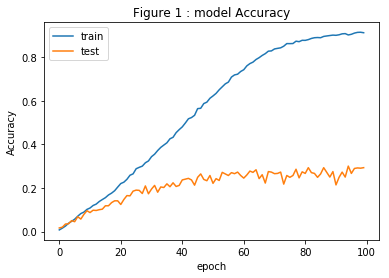

In [42]:
plt.plot(model_run_org.history['acc'])
plt.plot(model_run_org.history['val_acc'])
plt.title('Figure 1 : model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

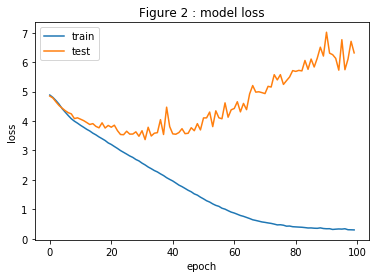

In [43]:
plt.plot(model_run_org.history['loss'])
plt.plot(model_run_org.history['val_loss'])
plt.title('Figure 2 : model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Load the Model with the Best Validation Loss (Without Image Augmentation)

In [18]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### Test the Model (Without Image Augmentation)

Try out your model on the test dataset of dog images.  Ensure that your test accuracy is greater than 1%.

In [19]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 17.3445%


### Takeaways

Figure 1 (Model Accuracy) and Figure 2 (Model Loss) indicate that the CNN model as defined above (without image augmentation) is overfitting the testing data since the test loss deciates from the training loss while the training loss keeps decreasing the test loss increases after just a few number of epochs. 

To improve the model performance we use image augmentation which helps in reducing this over-fitting thus enabling the model to give us better results as shown below. 

### (IMPLEMENTATION) Train the Model (With Image Augmentation)

We will train and test the model using image augmentation on the training dataset

In [20]:
from keras.callbacks import ModelCheckpoint 
import time

batch_size = 20
epochs = 100

Training_time_start = time.time()

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch_augmentation.hdf5', 
                               verbose=1, save_best_only=True)

model_run=model.fit_generator(datagen_train.flow(train_tensors, train_targets, batch_size=batch_size),
                    steps_per_epoch=train_tensors.shape[0] // batch_size,
                    epochs=epochs, verbose=2, callbacks=[checkpointer],
                    validation_data=(valid_tensors, valid_targets),
                    validation_steps=valid_tensors.shape[0] // batch_size)

Epoch 1/100
Epoch 00000: val_loss improved from inf to 4.86086, saving model to saved_models/weights.best.from_scratch_augmentation.hdf5
53s - loss: 4.8814 - acc: 0.0100 - val_loss: 4.8609 - val_acc: 0.0168
Epoch 2/100
Epoch 00001: val_loss did not improve
51s - loss: 4.8295 - acc: 0.0156 - val_loss: 4.8743 - val_acc: 0.0192
Epoch 3/100
Epoch 00002: val_loss improved from 4.86086 to 4.68471, saving model to saved_models/weights.best.from_scratch_augmentation.hdf5
51s - loss: 4.7485 - acc: 0.0232 - val_loss: 4.6847 - val_acc: 0.0228
Epoch 4/100
Epoch 00003: val_loss did not improve
51s - loss: 4.6646 - acc: 0.0340 - val_loss: 4.7052 - val_acc: 0.0419
Epoch 5/100
Epoch 00004: val_loss improved from 4.68471 to 4.47828, saving model to saved_models/weights.best.from_scratch_augmentation.hdf5
51s - loss: 4.5387 - acc: 0.0403 - val_loss: 4.4783 - val_acc: 0.0479
Epoch 6/100
Epoch 00005: val_loss improved from 4.47828 to 4.37576, saving model to saved_models/weights.best.from_scratch_augmenta

Epoch 00049: val_loss did not improve
51s - loss: 2.3870 - acc: 0.3783 - val_loss: 3.0005 - val_acc: 0.3210
Epoch 51/100
Epoch 00050: val_loss improved from 2.91653 to 2.89934, saving model to saved_models/weights.best.from_scratch_augmentation.hdf5
52s - loss: 2.3591 - acc: 0.3933 - val_loss: 2.8993 - val_acc: 0.2946
Epoch 52/100
Epoch 00051: val_loss did not improve
51s - loss: 2.3377 - acc: 0.4004 - val_loss: 3.0728 - val_acc: 0.3138
Epoch 53/100
Epoch 00052: val_loss did not improve
51s - loss: 2.3074 - acc: 0.4007 - val_loss: 3.0217 - val_acc: 0.3581
Epoch 54/100
Epoch 00053: val_loss did not improve
52s - loss: 2.2826 - acc: 0.4058 - val_loss: 3.4240 - val_acc: 0.2946
Epoch 55/100
Epoch 00054: val_loss did not improve
52s - loss: 2.2482 - acc: 0.4169 - val_loss: 3.1697 - val_acc: 0.3210
Epoch 56/100
Epoch 00055: val_loss improved from 2.89934 to 2.89778, saving model to saved_models/weights.best.from_scratch_augmentation.hdf5
51s - loss: 2.2379 - acc: 0.4243 - val_loss: 2.8978 - 

In [28]:
Training_time_with_Aug=int(time.time()-Training_time_start)
print("Total Training Time: " + str(int(time.time()-Training_time_start)) + " seconds")

Total Training Time: 6222 seconds


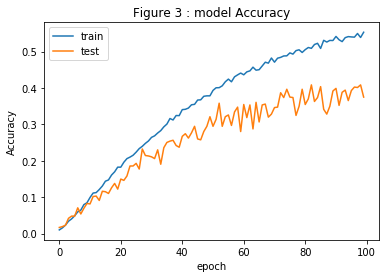

In [44]:
plt.plot(model_run.history['acc'])
plt.plot(model_run.history['val_acc'])
plt.title('Figure 3 : model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

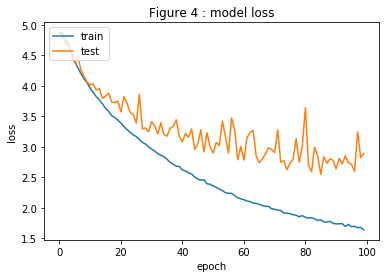

In [45]:
plt.plot(model_run.history['loss'])
plt.plot(model_run.history['val_loss'])
plt.title('Figure 4 : model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### (IMPLEMENTATION) Load the Model with the Best Validation Loss (With Image Augmentation)

In [20]:
model.load_weights('saved_models/weights.best.from_scratch_augmentation.hdf5')

### (IMPLEMENTATION) Test the model (With Image Augmentation)

In [21]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 39.5933%


### Takeaways

Figure 3 (Model Accuracy) and Figure 4 (Model Loss) indicate that the CNN model with image augmentation does significantly well when compared to the model without image augmentation. We could try improving the validation loss curve by reducing the learnign rate. In this case we dont since we would like to compare apples to apples how the exact model will do when we introduce image augmentation. Based on the model testing above, the test accuracy increases from 17% to close to 40%. 

---
<a id='step4'></a>
## Step 4: Use a CNN to Classify Dog Breeds

To reduce training time without sacrificing accuracy, we show you how to train a CNN using transfer learning.  In the following step, you will get a chance to use transfer learning to train your own CNN.

### Obtain Bottleneck Features

In [28]:
bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

### Model Architecture

The model uses the the pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 is fed as input to our model.  We only add a global average pooling layer and a fully connected layer, where the latter contains one node for each dog category and is equipped with a softmax.

In [29]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_3 ( (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 133)               68229     
Total params: 68,229.0
Trainable params: 68,229.0
Non-trainable params: 0.0
_________________________________________________________________


### Compile the Model

In [30]:
from keras import optimizers

VGG16_model.compile(loss='categorical_crossentropy', optimizer=optimizers.SGD(lr=1e-4, momentum=0.9), metrics=['accuracy'])

### Train the Model

In [99]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=53, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/53
6680/6680 [==============================] - 1s - loss: 12.7533 - acc: 0.0543 - val_loss: 10.7145 - val_acc: 0.1341
Epoch 2/53
6680/6680 [==============================] - 1s - loss: 9.2842 - acc: 0.1949 - val_loss: 8.4681 - val_acc: 0.2539
Epoch 3/53
6680/6680 [==============================] - 1s - loss: 7.4510 - acc: 0.3186 - val_loss: 7.3134 - val_acc: 0.3222
Epoch 4/53
6680/6680 [==============================] - 1s - loss: 6.4557 - acc: 0.3912 - val_loss: 6.7845 - val_acc: 0.3617
Epoch 5/53
6680/6680 [==============================] - 1s - loss: 5.8890 - acc: 0.4513 - val_loss: 6.3820 - val_acc: 0.3928
Epoch 6/53
6680/6680 [==============================] - 1s - loss: 5.4914 - acc: 0.4916 - val_loss: 6.0635 - val_acc: 0.4275
Epoch 7/53
6680/6680 [==============================] - 1s - loss: 5.1372 - acc: 0.5226 - val_loss: 5.7412 - val_acc: 0.4251
Epoch 8/53
6680/6680 [==============================] - 1s - loss: 4.7656 - 

6680/6680 [==============================] - 1s - loss: 2.4446 - acc: 0.8231 - val_loss: 3.7251 - val_acc: 0.5725
Epoch 28/53
6680/6680 [==============================] - 1s - loss: 2.4290 - acc: 0.8275 - val_loss: 3.7124 - val_acc: 0.5677
Epoch 29/53
6680/6680 [==============================] - 1s - loss: 2.4138 - acc: 0.8304 - val_loss: 3.7462 - val_acc: 0.5760
Epoch 30/53
6680/6680 [==============================] - 1s - loss: 2.4052 - acc: 0.8332 - val_loss: 3.7152 - val_acc: 0.5737
Epoch 31/53
6680/6680 [==============================] - 1s - loss: 2.3959 - acc: 0.8362 - val_loss: 3.7130 - val_acc: 0.5808
Epoch 32/53
6680/6680 [==============================] - 1s - loss: 2.3846 - acc: 0.8389 - val_loss: 3.6984 - val_acc: 0.5772
Epoch 33/53
6680/6680 [==============================] - 1s - loss: 2.3753 - acc: 0.8437 - val_loss: 3.6905 - val_acc: 0.5820
Epoch 34/53
6680/6680 [==============================] - 1s - loss: 2.3699 - acc: 0.8440 - val_loss: 3.6968 - val_acc: 0.5796
Epoc

### Load the Model with the Best Validation Loss

In [100]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

### Test the Model

Now, we can use the CNN to test how well it identifies breed within our test dataset of dog images.  We print the test accuracy below.

In [101]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 62.0813%


### Predict Dog Breed with the Model

In [24]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step5'></a>
## Step 5: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

In Step 4, we used transfer learning to create a CNN using VGG-16 bottleneck features.  In this section, you must use the bottleneck features from a different pre-trained model.  To make things easier for you, we have pre-computed the features for all of the networks that are currently available in Keras:
- [VGG-19](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz) bottleneck features
- [ResNet-50](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz) bottleneck features
- [Inception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz) bottleneck features
- [Xception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz) bottleneck features

The files are encoded as such:

    Dog{network}Data.npz
    
where `{network}`, in the above filename, can be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.  Pick one of the above architectures, download the corresponding bottleneck features, and store the downloaded file in the `bottleneck_features/` folder in the repository.

### (IMPLEMENTATION) Obtain Bottleneck Features

In the code block below, extract the bottleneck features corresponding to the train, test, and validation sets by running the following:

    bottleneck_features = np.load('bottleneck_features/Dog{network}Data.npz')
    train_{network} = bottleneck_features['train']
    valid_{network} = bottleneck_features['valid']
    test_{network} = bottleneck_features['test']

In [23]:
### Obtain bottleneck features from another pre-trained CNN.
bottleneck_features = np.load('bottleneck_features/DogInceptionV3Data.npz')
train_InceptionV3 = bottleneck_features['train']
valid_InceptionV3 = bottleneck_features['valid']
test_InceptionV3 = bottleneck_features['test']

In [51]:
train_InceptionV3.shape

(6680, 5, 5, 2048)

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        <your model's name>.summary()
   
__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 



In [77]:
### Define your architecture.
InceptionV3_model = Sequential()
# The pre-trained model us trained on the images that overlaps with the current dataset and thus by adding a global 
# average pooling2D we see that we can achieve an accuracy of 80% on the testing dataset
InceptionV3_model.add(GlobalAveragePooling2D(input_shape=train_InceptionV3.shape[1:]))
# Create the final output layer:
### Reasoning: We define the output shape to be 133 since there are 133 dog breeds (133 classes) and use softmax
### activation function since we want to return the probability the image belonging to each class (dog breed).
InceptionV3_model.add(Dense(133, activation='softmax'))
InceptionV3_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_7 ( (None, 2048)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 133)               272517    
Total params: 272,517.0
Trainable params: 272,517.0
Non-trainable params: 0.0
_________________________________________________________________


### (IMPLEMENTATION) Compile the Model

In [42]:
### Compile the model.
# Loss: Categorical_crossentropy is used since the targets are in categorical format 
# optimizer: sgd is used with a very small learning rate to enable better convergence to the best accuracy 
# and minimum loss
InceptionV3_model.compile(loss='categorical_crossentropy', optimizer=optimizers.SGD(lr=1e-4, momentum=0.9), metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.  

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [43]:
### Train the model.
import time
from keras.callbacks import ModelCheckpoint

Training_time_start_V3 = time.time()

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.InceptionV3.hdf5', 
                               verbose=1, save_best_only=True)

### Training model
InceptionV3_model_1=InceptionV3_model.fit(train_InceptionV3, train_targets, 
          validation_data=(valid_InceptionV3, valid_targets),
          epochs=200, batch_size=20, callbacks=[checkpointer], verbose=1)


Train on 6680 samples, validate on 835 samples
Epoch 1/200
6680/6680 [==============================] - 2s - loss: 4.7894 - acc: 0.0430 - val_loss: 4.2603 - val_acc: 0.1281
Epoch 2/200
6680/6680 [==============================] - 2s - loss: 3.8400 - acc: 0.2512 - val_loss: 3.4330 - val_acc: 0.3868
Epoch 3/200
6680/6680 [==============================] - 2s - loss: 3.0856 - acc: 0.4624 - val_loss: 2.7699 - val_acc: 0.5557
Epoch 4/200
6680/6680 [==============================] - 2s - loss: 2.4921 - acc: 0.5888 - val_loss: 2.2604 - val_acc: 0.6371
Epoch 5/200
6680/6680 [==============================] - 2s - loss: 2.0467 - acc: 0.6696 - val_loss: 1.8858 - val_acc: 0.6898
Epoch 6/200
6680/6680 [==============================] - 2s - loss: 1.7209 - acc: 0.7136 - val_loss: 1.6134 - val_acc: 0.7246
Epoch 7/200
6680/6680 [==============================] - 2s - loss: 1.4830 - acc: 0.7463 - val_loss: 1.4150 - val_acc: 0.7449
Epoch 8/200
6680/6680 [==============================] - 2s - loss: 1.3

6680/6680 [==============================] - 2s - loss: 0.5479 - acc: 0.8687 - val_loss: 0.6325 - val_acc: 0.8395
Epoch 27/200
6680/6680 [==============================] - 2s - loss: 0.5361 - acc: 0.8737 - val_loss: 0.6243 - val_acc: 0.8371
Epoch 28/200
6680/6680 [==============================] - 2s - loss: 0.5252 - acc: 0.8743 - val_loss: 0.6164 - val_acc: 0.8383
Epoch 29/200
6680/6680 [==============================] - 2s - loss: 0.5148 - acc: 0.8777 - val_loss: 0.6088 - val_acc: 0.8383
Epoch 30/200
6680/6680 [==============================] - 2s - loss: 0.5051 - acc: 0.8790 - val_loss: 0.6015 - val_acc: 0.8407
Epoch 31/200
6680/6680 [==============================] - 2s - loss: 0.4958 - acc: 0.8802 - val_loss: 0.5958 - val_acc: 0.8431
Epoch 32/200
6680/6680 [==============================] - 2s - loss: 0.4872 - acc: 0.8822 - val_loss: 0.5900 - val_acc: 0.8443
Epoch 33/200
6680/6680 [==============================] - 2s - loss: 0.4790 - acc: 0.8828 - val_loss: 0.5845 - val_acc: 0.84

6680/6680 [==============================] - 2s - loss: 0.3769 - acc: 0.9069 - val_loss: 0.5253 - val_acc: 0.8503
Epoch 52/200
6680/6680 [==============================] - 2s - loss: 0.3729 - acc: 0.9078 - val_loss: 0.5237 - val_acc: 0.8479
Epoch 53/200
6680/6680 [==============================] - 2s - loss: 0.3689 - acc: 0.9081 - val_loss: 0.5210 - val_acc: 0.8491
Epoch 54/200
6680/6680 [==============================] - 2s - loss: 0.3651 - acc: 0.9093 - val_loss: 0.5194 - val_acc: 0.8515
Epoch 55/200
6680/6680 [==============================] - 2s - loss: 0.3613 - acc: 0.9094 - val_loss: 0.5181 - val_acc: 0.8527
Epoch 56/200
6680/6680 [==============================] - 2s - loss: 0.3576 - acc: 0.9108 - val_loss: 0.5165 - val_acc: 0.8539
Epoch 57/200
6680/6680 [==============================] - 2s - loss: 0.3540 - acc: 0.9121 - val_loss: 0.5152 - val_acc: 0.8515
Epoch 58/200
6680/6680 [==============================] - 2s - loss: 0.3505 - acc: 0.9127 - val_loss: 0.5133 - val_acc: 0.85

6680/6680 [==============================] - 2s - loss: 0.2966 - acc: 0.9259 - val_loss: 0.4924 - val_acc: 0.8539
Epoch 78/200
6680/6680 [==============================] - 2s - loss: 0.2943 - acc: 0.9280 - val_loss: 0.4917 - val_acc: 0.8551
Epoch 79/200
6680/6680 [==============================] - 2s - loss: 0.2919 - acc: 0.9272 - val_loss: 0.4908 - val_acc: 0.8539
Epoch 80/200
6680/6680 [==============================] - 2s - loss: 0.2897 - acc: 0.9284 - val_loss: 0.4899 - val_acc: 0.8563
Epoch 81/200
6680/6680 [==============================] - 2s - loss: 0.2874 - acc: 0.9283 - val_loss: 0.4891 - val_acc: 0.8551
Epoch 82/200
6680/6680 [==============================] - 2s - loss: 0.2853 - acc: 0.9290 - val_loss: 0.4884 - val_acc: 0.8539
Epoch 83/200
6680/6680 [==============================] - 2s - loss: 0.2832 - acc: 0.9296 - val_loss: 0.4879 - val_acc: 0.8527
Epoch 84/200
6680/6680 [==============================] - 2s - loss: 0.2811 - acc: 0.9308 - val_loss: 0.4874 - val_acc: 0.85

6680/6680 [==============================] - 2s - loss: 0.2477 - acc: 0.9419 - val_loss: 0.4779 - val_acc: 0.8563
Epoch 103/200
6680/6680 [==============================] - 2s - loss: 0.2461 - acc: 0.9431 - val_loss: 0.4779 - val_acc: 0.8599
Epoch 104/200
6680/6680 [==============================] - 2s - loss: 0.2445 - acc: 0.9442 - val_loss: 0.4773 - val_acc: 0.8599
Epoch 105/200
6680/6680 [==============================] - 2s - loss: 0.2429 - acc: 0.9428 - val_loss: 0.4765 - val_acc: 0.8599
Epoch 106/200
6680/6680 [==============================] - 2s - loss: 0.2414 - acc: 0.9457 - val_loss: 0.4761 - val_acc: 0.8599
Epoch 107/200
6680/6680 [==============================] - 2s - loss: 0.2398 - acc: 0.9446 - val_loss: 0.4765 - val_acc: 0.8575
Epoch 108/200
6680/6680 [==============================] - 2s - loss: 0.2383 - acc: 0.9446 - val_loss: 0.4763 - val_acc: 0.8587
Epoch 109/200
6680/6680 [==============================] - 2s - loss: 0.2368 - acc: 0.9457 - val_loss: 0.4758 - val_ac

6680/6680 [==============================] - 2s - loss: 0.2103 - acc: 0.9555 - val_loss: 0.4703 - val_acc: 0.8599
Epoch 130/200
6680/6680 [==============================] - 2s - loss: 0.2091 - acc: 0.9566 - val_loss: 0.4702 - val_acc: 0.8587
Epoch 131/200
6680/6680 [==============================] - 2s - loss: 0.2080 - acc: 0.9569 - val_loss: 0.4702 - val_acc: 0.8599
Epoch 132/200
6680/6680 [==============================] - 2s - loss: 0.2068 - acc: 0.9572 - val_loss: 0.4697 - val_acc: 0.8611
Epoch 133/200
6680/6680 [==============================] - 2s - loss: 0.2057 - acc: 0.9573 - val_loss: 0.4695 - val_acc: 0.8599
Epoch 134/200
6680/6680 [==============================] - 2s - loss: 0.2045 - acc: 0.9582 - val_loss: 0.4690 - val_acc: 0.8599
Epoch 135/200
6680/6680 [==============================] - 2s - loss: 0.2033 - acc: 0.9594 - val_loss: 0.4688 - val_acc: 0.8599
Epoch 136/200
6680/6680 [==============================] - 2s - loss: 0.2022 - acc: 0.9590 - val_loss: 0.4690 - val_ac

6680/6680 [==============================] - 2s - loss: 0.1833 - acc: 0.9660 - val_loss: 0.4660 - val_acc: 0.8587
Epoch 156/200
6680/6680 [==============================] - 2s - loss: 0.1824 - acc: 0.9659 - val_loss: 0.4663 - val_acc: 0.8563
Epoch 157/200
6680/6680 [==============================] - 2s - loss: 0.1815 - acc: 0.9663 - val_loss: 0.4656 - val_acc: 0.8611
Epoch 158/200
6680/6680 [==============================] - 2s - loss: 0.1806 - acc: 0.9662 - val_loss: 0.4656 - val_acc: 0.8599
Epoch 159/200
6680/6680 [==============================] - 2s - loss: 0.1797 - acc: 0.9674 - val_loss: 0.4658 - val_acc: 0.8611
Epoch 160/200
6680/6680 [==============================] - 2s - loss: 0.1788 - acc: 0.9672 - val_loss: 0.4656 - val_acc: 0.8599
Epoch 161/200
6680/6680 [==============================] - 2s - loss: 0.1779 - acc: 0.9674 - val_loss: 0.4657 - val_acc: 0.8611
Epoch 162/200
6680/6680 [==============================] - 2s - loss: 0.1771 - acc: 0.9687 - val_loss: 0.4654 - val_ac

6680/6680 [==============================] - 2s - loss: 0.1600 - acc: 0.9735 - val_loss: 0.4637 - val_acc: 0.8539
Epoch 185/200
6680/6680 [==============================] - 2s - loss: 0.1594 - acc: 0.9729 - val_loss: 0.4636 - val_acc: 0.8563
Epoch 186/200
6680/6680 [==============================] - 2s - loss: 0.1587 - acc: 0.9735 - val_loss: 0.4637 - val_acc: 0.8539
Epoch 187/200
6680/6680 [==============================] - 2s - loss: 0.1580 - acc: 0.9743 - val_loss: 0.4634 - val_acc: 0.8563
Epoch 188/200
6680/6680 [==============================] - 2s - loss: 0.1573 - acc: 0.9737 - val_loss: 0.4631 - val_acc: 0.8587
Epoch 189/200
6680/6680 [==============================] - 2s - loss: 0.1567 - acc: 0.9740 - val_loss: 0.4633 - val_acc: 0.8563
Epoch 190/200
6680/6680 [==============================] - 2s - loss: 0.1560 - acc: 0.9746 - val_loss: 0.4634 - val_acc: 0.8563
Epoch 191/200
6680/6680 [==============================] - 2s - loss: 0.1554 - acc: 0.9751 - val_loss: 0.4632 - val_ac

In [44]:
Training_time_Incept_org=int(time.time()-Training_time_start_V3)
print("Total Training Time: " + str(Training_time_Incept_org) + " seconds")

Total Training Time: 424 seconds


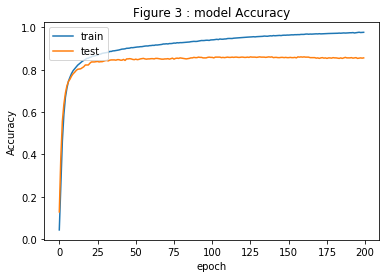

In [45]:
plt.plot(InceptionV3_model_1.history['acc'])
plt.plot(InceptionV3_model_1.history['val_acc'])
plt.title('Figure 3 : model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

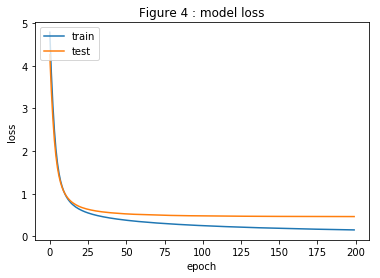

In [46]:
plt.plot(InceptionV3_model_1.history['loss'])
plt.plot(InceptionV3_model_1.history['val_loss'])
plt.title('Figure 4 : model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### (IMPLEMENTATION) Load the Model with the Best Validation Loss

In [47]:
### TODO: Load the model weights with the best validation loss.
InceptionV3_model.load_weights('saved_models/weights.best.InceptionV3.hdf5')

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Ensure that your test accuracy is greater than 60%.

In [67]:
### Calculate classification accuracy on the test dataset.
# get index of predicted dog breed for each image in test set
InceptionV3_predictions = [np.argmax(InceptionV3_model.predict(np.expand_dims(feature, axis=0))) for feature in test_InceptionV3]

# report test accuracy
test_accuracy = 100*np.sum(np.array(InceptionV3_predictions)==np.argmax(test_targets, axis=1))/len(InceptionV3_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 82.7751%


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan_hound`, etc) that is predicted by your model.  

Similar to the analogous function in Step 5, your function should have three steps:
1. Extract the bottleneck features corresponding to the chosen CNN model.
2. Supply the bottleneck features as input to the model to return the predicted vector.  Note that the argmax of this prediction vector gives the index of the predicted dog breed.
3. Use the `dog_names` array defined in Step 0 of this notebook to return the corresponding breed.

The functions to extract the bottleneck features can be found in `extract_bottleneck_features.py`, and they have been imported in an earlier code cell.  To obtain the bottleneck features corresponding to your chosen CNN architecture, you need to use the function

    extract_{network}
    
where `{network}`, in the above filename, should be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.

In [58]:
### Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.
def InceptionV3_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_InceptionV3(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = InceptionV3_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

### Modifying function for mix-breed dog

Rather than just showing the breed in the case of a dog (mix-breed) detected in the image, we output the 
probability of the mix as well as the associated breed in the case that a mix-breed is detected. If the highest probability of the breed detected is greater than 80% then we output the result as the dog belonging to a single breed

In [59]:
# Modifying the above function to output mix breed
def InceptionV3_predict_Mod_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_InceptionV3(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = InceptionV3_model.predict(bottleneck_feature)
    # Find the highest probability
    prob_high = predicted_vector.item(np.argmax(predicted_vector))
    high_pos=np.argmax(predicted_vector)
    if prob_high>=0.8:
        return dog_names[np.argmax(predicted_vector)] 
    else:
        prob_second_high = predicted_vector.item(np.argsort(predicted_vector).item(-2))
        second_high_pos = np.argsort(predicted_vector).item(-2)
        return "{0:.0f}%".format(prob_high * 100) + ' ' + dog_names[high_pos] + ' and ' \
    + "{0:.0f}%".format(prob_second_high * 100) + ' ' + dog_names[second_high_pos]

---
<a id='step6'></a>
## Step 6: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `dog_detector` functions developed above.  You are __required__ to use your CNN from Step 5 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [60]:
import matplotlib.image as mpimg
from scipy import ndimage
path = 'images/Brittany_02625.jpg'

In [61]:
def predict_dog_breed(img_path):
    if face_detector(img_path) == True:
        breed=InceptionV3_predict_breed(img_path)
        print('\n Hello, Human! \n')
        img = mpimg.imread(img_path)
        plt.imshow(img)
        plt.show()
        print('You look like a...... \n')
        return breed
    elif dog_detector(img_path) == True:
        breed=InceptionV3_predict_Mod_breed(img_path)
        print('\n Hello, my Friend! \n')
        img = mpimg.imread(img_path)
        plt.imshow(img)
        plt.show()
        print('Your predicted breed is..... \n')
        return breed
    else:
        print('ERROR!!!!')
        img = mpimg.imread(img_path)
        plt.imshow(img)
        plt.show()
        return 'Neither Dog or Human Detected in above Image \n'
    


 Hello, my Friend! 



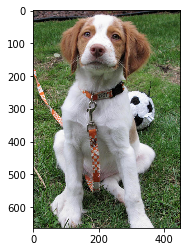

Your predicted breed is..... 

Brittany


In [62]:
print(predict_dog_breed(path))

---
<a id='step7'></a>
## Step 7: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that __you__ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ 

I believe the model gives expected results which are quite good, though I beleive the following improvements can be made to the model:

1. The face detector is not very efficient in detecting human if the image is not that of a an image with eyes closed and the person making a distorted face. When the face of the human is purposely distorted where in the features are not clearly visible, the face detector does not recognize the image is that of a human. In order to make this better, the face detector aspect of the algorithm would be needed to be revisted. That being said, trying another "haarcascades" face detector (haarcascade_frontalface_alt2.xml) as displayed above improved the accuracy ever-so slightly but also increased the false positives (20% of dogs detected as humans). Another suggestion is to run through another detector that would detect features that are not generally obvious.

2. The model does recognize that a dog is present in the picture even if there are multiple animals. That being said, the picture needs to be of good quality and the dog should be clearly visible. One way of improving this is to add image augmentation where we could augment the testing data set with images that shifts images and as well as orients images differently to expand the dataset.

3. One more improvment could be to improve the model to detect multiple dogs, right now the dog that is first detected in the image is extracted and the breed is predicted.Ideally we would like multiple dogs detected and generate a message mentioning the breed of dogs detected and furthermore we can build upon this making it a very complex use case but defintiely something worth pondering

4. based on the results below, the breeds of humans tend to on more occasions then not return a Canaan dog breed. May be most humans look like a Canaan dog but that probably is sonething to improve, may be image augmentation of dog images could help?? :D

5. Looks like the face detector detects humans in images that contain objects that are not necessarily fall in this category. Ideally we would need to use multiple detectors in tandem rather than just 2 (face detector and dog detector) to remove these false positives. 


 Hello, my Friend! 



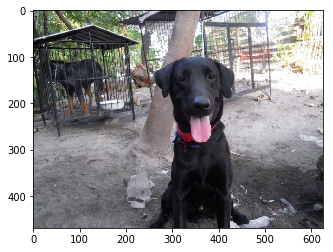

Your predicted breed is..... 

Labrador_retriever

 Hello, my Friend! 



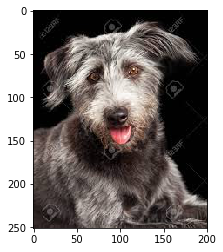

Your predicted breed is..... 

Glen_of_imaal_terrier
ERROR!!!!


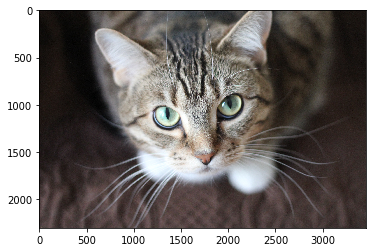

Neither Dog or Human Detected in above Image 


 Hello, my Friend! 



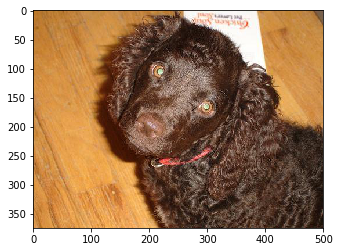

Your predicted breed is..... 

76% American_water_spaniel and 14% Irish_water_spaniel

 Hello, my Friend! 



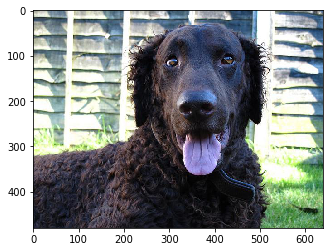

Your predicted breed is..... 

Curly-coated_retriever

 Hello, Human! 



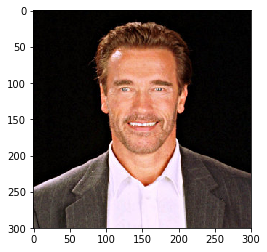

You look like a...... 

Canaan_dog

 Hello, Human! 



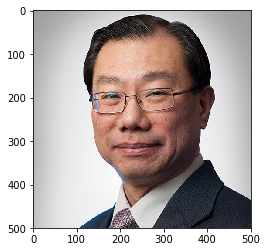

You look like a...... 

Canaan_dog

 Hello, Human! 



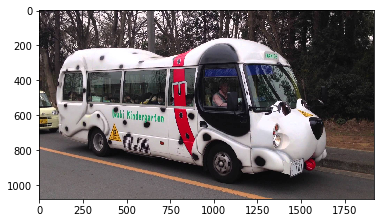

You look like a...... 

Canaan_dog

 Hello, my Friend! 



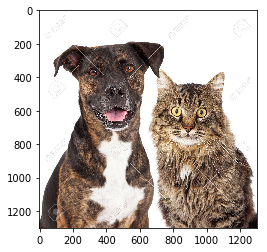

Your predicted breed is..... 

36% American_staffordshire_terrier and 31% Cane_corso

 Hello, Human! 



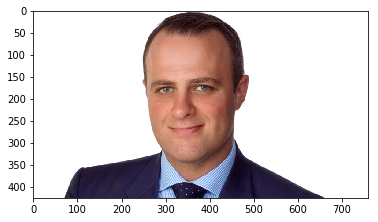

You look like a...... 

Canaan_dog


In [66]:
## Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.
import os
path = 'images/Test_Folder/'
for filename in os.listdir(path):
    try:
        img_path=os.path.join(path, filename)
        print(predict_dog_breed(img_path))
    except:
        pass